<a href="https://colab.research.google.com/github/Yuan325/CSCI6364_MachineLearning/blob/main/Project3/KMeans_PCA_HumanActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/ruslankl/k-means-clustering-pca

use k-means clustering and PCA

In [ ]:
# graph template functions
def printHistogram(x, name = "Data"):
  q25, q75 = np.percentile(x,[25,75])
  bin_width = 2*(q75 - q25)*len(x)**(-1/3)
  bins = round((np.amax(x) - np.amin(x))/bin_width)
  print("Freedman–Diaconis number of bins:", bins)

  plt.style.use('seaborn-whitegrid')
  plt.hist(x, density = True, bins = bins, label=name) # density false make counts, true make probability
  mn, mx = plt.xlim()
  plt.xlim(mn, mx)
  kde_xs = np.linspace(mn, mx, 1000)
  kde = st.gaussian_kde(x)
  plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
  plt.legend(loc="upper right")
  plt.ylabel('Probability')
  plt.xlabel(name)
  plt.title("Histogram")
  plt.show()

def lineGraph(labels, values, labeltitle="Label", valuetitle="Values"):
  plt.figure(figsize=(8,5))
  plt.style.use('bmh')
  plt.plot(labels, values, '-o')
  plt.xlabel(labeltitle)
  plt.ylabel(valuetitle)
  plt.xticks(labels)
  plt.show()

In [ ]:
from google.colab import files

files.upload() # upload human activity .csv data file 

In [ ]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import scipy.stats as st

In [ ]:
reader = csv.reader(open('/content/human_activity.csv', 'r'))
header = next(reader)
data = []
for row in reader: 
  data.append(row)
data = np.array(data)

# remove first column: rn
header = header[1:]
data = data[:, 1:]

np.random.shuffle(data)
data = np.array(data)

#3609 dataset
split1 = 2887 # 80/10/10 split
split2 = 3248
train_data = data[:split1, :]
val_data = data[split1:split2, :]
test_data = data[split2:, :]

train_x = train_data[:,1:].astype(np.float)
train_y = train_data[:,0]
val_x = val_data[:,1:].astype(np.float)
val_y = val_data[:,0]
test_x = test_data[:,1:].astype(np.float)
test_y = test_data[:,0]

Freedman–Diaconis number of bins: 346


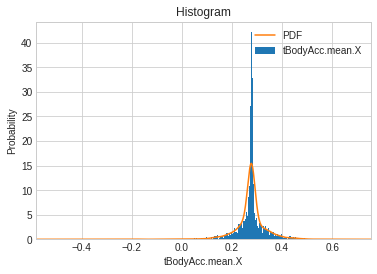

Freedman–Diaconis number of bins: 468


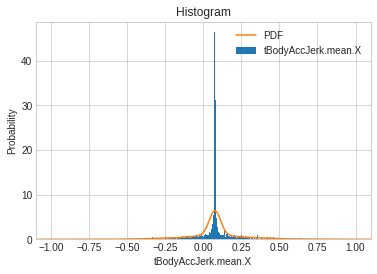

Freedman–Diaconis number of bins: 102


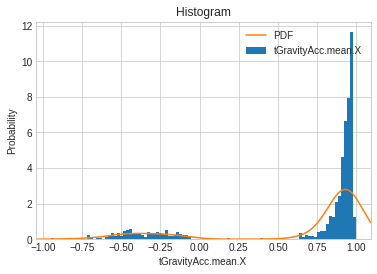

In [ ]:
# visualize data
printHistogram(train_x[:,0], "tBodyAcc.mean.X")
printHistogram(train_x[:,80], "tBodyAccJerk.mean.X")
printHistogram(train_x[:,40], "tGravityAcc.mean.X")

In [ ]:
class PCA:
  def normalization(self, x):
    self.min = []
    self.max = []
    for i in range(len(x[0])):
      self.min.append(np.amin(x[:,i]))
      self.max.append(np.amax(x[:,i]))
    x = self.applyNorm(x)
    return x

  def run(self, xs):
    self.x = self.normalization(xs)
    cov_mat = np.cov(self.x.T)
    self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov_mat)
    sort = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sort]
    self.eigenvectors = self.eigenvectors[:,sort]
    self.variances = []
    for v in self.eigenvalues:
      self.variances.append(v/np.sum(self.eigenvalues))
    return self.variances

  def pickComponent(self):
    tot = 0
    for i in range(len(self.variances)):
      tot += self.variances[i]
      if tot > 0.9:
        self.n = i
        break
    return self.n

  def applyNorm(self, x):
    for i in range(len(self.min)):
      x[:,i]=(x[:,i] - self.min[i]) / (self.max[i]-self.min[i])
    return x

  def transform(self, x):
    return np.dot(self.applyNorm(x), self.eigenvectors[:, :self.n])

In [ ]:
class KMeans:
  def __init__(self, k):
    self.k = k
    self.centroids = []
    self.yhat = []

  def fit(self, xs, train_y):
    n = len(xs)
    rand = random.sample(range(0,n), self.k)
    for r in rand:
      self.centroids.append(xs[r])

    self.yhat = [-1] * n
    while True:
      temp = []
      for x in xs:
        temp.append(self.assignPoints(x))
      if all(map(lambda x,y: x==y, temp, self.yhat)):
        break
      self.yhat = temp
      
      for i in range(len(self.centroids)):
        self.centroids[i] = self.getCentroid(i, xs)

    self.tr_result, self.tr_result_set = self.clusterTrainingResults(self.yhat, train_y)
    return self.tr_result, self.tr_result_set

  def assignPoints(self, x):
    min_dist = float('inf')
    clus = -1
    for ind, c in enumerate(self.centroids): 
      dist = self.euclideanDistance(x, c)
      if dist < min_dist:
        clus = ind
        min_dist = dist
    return clus

  def euclideanDistance(self, x1, x2):
    temp = x1-x2
    dist = np.sum(temp*temp)
    return np.sqrt(dist)

  def getCentroid(self, cluster, xs):
    tot = np.zeros(len(xs[0]))
    count = 0
    for yh, x in zip(self.yhat, xs):
      if yh == cluster:
        tot += x
        count += 1 
    return tot/count

  def predict(self, xs):
    temp = []
    for x in xs:
        temp.append(self.assignPoints(x))
    return temp

  def clusterTrainingResults(self, pred, ys):
    n_set = list(set(ys))
    cluster_count = []
    for i in range(len(self.centroids)):
      categories = np.zeros(len(n_set))
      for yh, y in zip(pred, ys):
        if yh == i:
          categories[n_set.index(y)] += 1
      cluster_count.append(categories)
    return cluster_count, n_set

  def averageWithinClusterDist(self, xs, pred):
    tot = 0
    for x, y in zip(xs, pred):
      tot += self.euclideanDistance(x, self.centroids[y])
    return tot/len(xs)

In [ ]:
# evaluation metrics
def accuracy(tn, fp, fn, tp):
  return (tp + tn)/(tp+tn+fp+fn)

def f1score(tn, fp, fn, tp):
  return 2*tp/(2*tp + fp + fn)

In [ ]:
pca = PCA()
pca.run(copy.deepcopy(train_x))
pca.pickComponent()

train_pca_x = pca.transform(train_x)
val_pca_x = pca.transform(val_x)

Freedman–Diaconis number of bins: 17


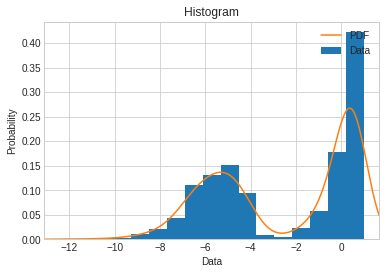

Freedman–Diaconis number of bins: 6


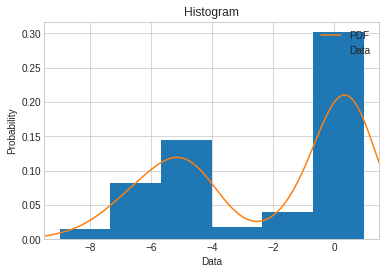

In [ ]:
printHistogram(train_pca_x[:,0])
printHistogram(val_pca_x[:,0])

[3.509537691308416, 2.150504940569883, 2.0081439868225877, 1.934153866788958, 1.8094401869558918, 1.7836822191034998, 1.754032702821196, 1.7171940671456973]


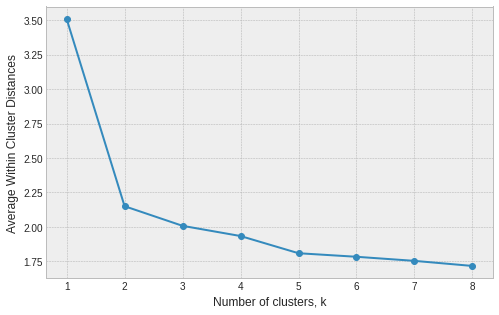

In [ ]:
ks = [1,2,3,4,5,6,7,8]
kmodels = []
withinClusDist = []
for k in ks:
  kmeans = KMeans(k)
  tr_result, tr_result_set = kmeans.fit(train_pca_x, train_y)

  pred = kmeans.predict(val_pca_x)
  withinClusDist.append(kmeans.averageWithinClusterDist(val_pca_x, pred))
  kmodels.append(kmeans)

print(withinClusDist)
lineGraph(ks, withinClusDist, labeltitle="Number of clusters, k", valuetitle="Average Within Cluster Distances")


In [ ]:
# run test data! 
model = ks.index(2)
val_pca_x = pca.transform(val_x)

test_pca_x = pca.transform(test_x)
pred = kmodels[model].predict(test_pca_x)

print("kmeans model with k=", ks[model], " .")
cluster_count, n_set = kmodels[model].clusterTrainingResults(kmodels[model].yhat, train_y)
print("values for each column: ", n_set)
print("\ntraining dataset: ",)
for i in range(ks[model]):
  print("cluster ", i+1, ": ", cluster_count[i])

cluster_count, n_set = kmodels[model].clusterTrainingResults(pred, test_y)
print("\ntesting dataset: ")
for i in range(ks[model]):
  print("cluster ", i+1, ": ", cluster_count[i])

kmeans model with k= 2  .
values for each column:  ['WALKING_DOWNSTAIRS', 'WALKING', 'WALKING_UPSTAIRS', 'SITTING', 'STANDING', 'LAYING']

training dataset: 
cluster  1 :  [412. 472. 433.   1.   0.   1.]
cluster  2 :  [  0.   0.   0. 502. 539. 527.]

testing dataset: 
cluster  1 :  [41. 69. 54.  0.  0.  0.]
cluster  2 :  [ 0.  0.  0. 53. 71. 73.]


In [ ]:
cluster1 = ['SITTING', 'LAYING', 'STANDING']
cluster2 = ['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

# for k = 2 
cl_true = cluster_count[0][0] + cluster_count[0][1] + cluster_count[0][2]   # tp
c1_false = cluster_count[0][3] + cluster_count[0][4] + cluster_count[0][5]  # fn
c2_true = cluster_count[1][3] + cluster_count[1][4] + cluster_count[1][5]   # tn
c2_false = cluster_count[1][0] + cluster_count[1][1] + cluster_count[1][2]  # fp

In [ ]:
acc = accuracy(c2_true, c2_false, c1_false, cl_true)
f1 = f1score(c2_true, c2_false, c1_false, cl_true)

print("accuracy for test data: ", acc)
print("f1 score for test data: ", f1)

accuracy for test data:  1.0
f1 score for test data:  1.0
